# Dogs vs Cats

from kaggle contest:

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

## Download Dataset

In [1]:
import os

TMP_DIR = './tmp/'

def make_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)

make_dir(TMP_DIR)

In [2]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -f train.zip -p './tmp'
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -f test.zip -p './tmp'

401 - Unauthorized
401 - Unauthorized


In [3]:
!unzip -uq tmp/train.zip -d tmp/
!unzip -uq tmp/test.zip -d tmp/

In [4]:
import random

train_validation_split = 0.9

make_dir('./tmp/train-data')
make_dir('./tmp/train-data/dog')
make_dir('./tmp/train-data/cat')

make_dir('./tmp/validation-data')
make_dir('./tmp/validation-data/dog')
make_dir('./tmp/validation-data/cat')

for base, _, filenames in os.walk('./tmp/train'):
    cats = [name for name in filenames if 'cat' in name ]
    dogs = [name for name in filenames if 'dog' in name ]
    random.seed(42)
    random.shuffle(cats)
    random.seed(42)
    random.shuffle(dogs)
    
    cats_number = len(cats)
    dogs_number = len(dogs)
    
    train_cats = cats[:int(cats_number*train_validation_split)]
    validation_cats = cats[int(cats_number*train_validation_split):]
    
    train_dogs = dogs[:int(dogs_number*train_validation_split)]
    validation_dogs = dogs[int(dogs_number*train_validation_split):]
    
    for name in train_cats:
        os.rename(base + '/' + name, './tmp/train-data' + '/cat/' + name)
        
    for name in validation_cats:
        os.rename(base + '/' + name, './tmp/validation-data' + '/cat/' + name)
        
    for name in train_dogs:
        os.rename(base + '/' + name, './tmp/train-data' + '/dog/' + name)
        
    for name in validation_dogs:
        os.rename(base + '/' + name, './tmp/validation-data' + '/dog/' + name)

## Exploration

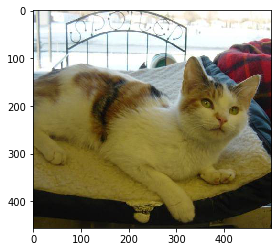

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

CATS_DIR = './tmp/train-data/cat/'
cats = os.listdir(CATS_DIR)
img = matplotlib.image.imread(CATS_DIR + cats[0])
plt.imshow(img)

## Model Training

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          3

In [8]:
model.compile(loss='binary_crossentropy',
              optimizers=keras.optimizers.RMSprop(lr=0.001),
              metrics=['acc']
             )

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = train_datagen.flow_from_directory(
    './tmp/train-data',
    target_size=(100, 100),
    batch_size=100,
    class_mode='binary'
)
validation_datagen = ImageDataGenerator(
    rescale=1./255
)
validation_generator = validation_datagen.flow_from_directory(
    './tmp/validation-data',
    target_size=(100, 100),
    batch_size=100,
    class_mode='binary'
)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [10]:
history = model.fit_generator(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

Epoch 1/25
225/225 [==============================] - 150s 666ms/step - loss: 0.6561 - acc: 0.6043 - val_loss: 0.5634 - val_acc: 0.7244
Epoch 2/25
225/225 [==============================] - 150s 668ms/step - loss: 0.5522 - acc: 0.7200 - val_loss: 0.4815 - val_acc: 0.7848
Epoch 3/25
225/225 [==============================] - 149s 660ms/step - loss: 0.4762 - acc: 0.7718 - val_loss: 0.4848 - val_acc: 0.7696
Epoch 4/25
225/225 [==============================] - 133s 590ms/step - loss: 0.4252 - acc: 0.8024 - val_loss: 0.4688 - val_acc: 0.7844
Epoch 5/25
225/225 [==============================] - 140s 622ms/step - loss: 0.3829 - acc: 0.8232 - val_loss: 0.3717 - val_acc: 0.8372
Epoch 6/25
225/225 [==============================] - 157s 698ms/step - loss: 0.3394 - acc: 0.8497 - val_loss: 0.3579 - val_acc: 0.8488
Epoch 7/25
225/225 [==============================] - 149s 663ms/step - loss: 0.3088 - acc: 0.8645 - val_loss: 0.3374 - val_acc: 0.8552
Epoch 8/25
225/225 [============================

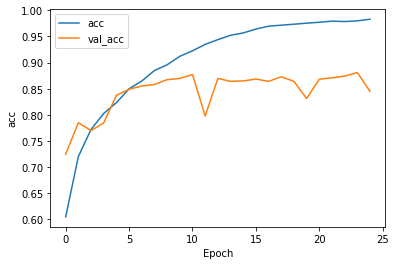

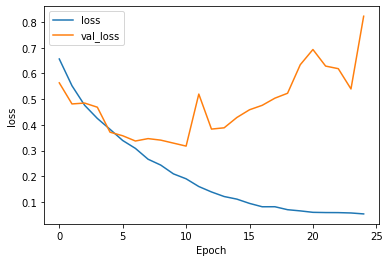

In [11]:
def plot_graph(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.show()

plot_graph(history, 'acc')
plot_graph(history, 'loss')